In [1]:
### Load pore structure and LB simulation data


import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import pickle
import scipy.io as sio

imageSize = 250

poreImage = np.load('finalSimFile3D_out.npy')
#poreImage = poreImage[0:imageSize, 0:imageSize, 0:250]

velMat = sio.loadmat('velNormOut.mat')
velDataNorm = velMat['velNorm']
# with open('velNorm.pkl', 'rb') as fin :
#     velNorm = pickle.load(fin)

#poreVelocity = np.reshape(poreVelocity, (imageSize, imageSize, imageSize))



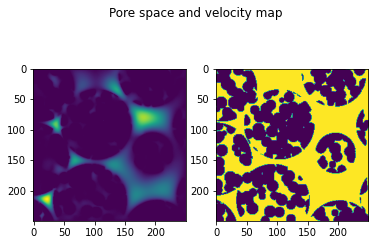

In [2]:
slice = 49

poreImage = np.load('finalSimFile3D_out.npy')
#JUST MIRROR ONE OF THESE
poreImage = np.transpose(poreImage)
#poreImage = np.flip(poreImage, (2,0,1))
#poreImage = np.flipud(poreImage)
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNorm[:,:,slice])
p2.imshow(poreImage[:,:,slice])
#im_3d = ps.visualization.show_3D(velDataNorm)
#plt.imshow(im_3d, cmap=plt.cm.moagma);
#plt.show()


In [25]:
ps.io.to_vtk(velDataNorm,'velVTKOut')
ps.io.to_vtk(poreImage,'poreStructureOut')

In [3]:
snowFilt = ps.filters.snow_partitioning(im=poreImage, return_all=True)


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1548
Peaks after trimming saddle points:  1005
Peaks after trimming nearby peaks:  983


In [5]:
poreInfo = ps.networks.regions_to_network(snowFilt.regions)


------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 983/983 [00:10<00:00, 94.93it/s] 


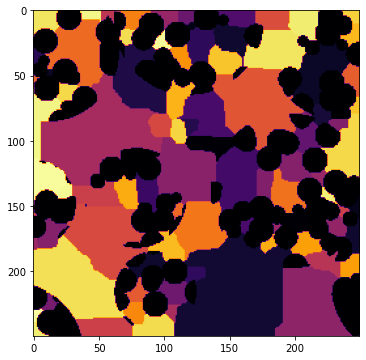

In [6]:
slice = 0
plt.subplots(1, 1, figsize=(6, 6))
fig = plt.imshow(snowFilt.regions[0:imageSize, 0:imageSize, slice], cmap=plt.cm.inferno)

In [7]:
snowFilt.regions[0:imageSize, 0:imageSize, slice]

array([[895, 895, 895, ..., 854, 854, 854],
       [895, 895, 895, ..., 854, 854, 854],
       [895, 895, 895, ..., 854, 854, 854],
       ...,
       [914, 914, 914, ...,   0,   0,   0],
       [914, 914, 914, ...,   0,   0,   0],
       [914, 914, 914, ...,   0,   0, 291]])

In [8]:

cubeSize = len(poreImage)

velocitiesPore = {}

regionMap = snowFilt.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMap[a,b,c])
            if key != '0.0':
                if key in velocitiesPore:
                    velocitiesPore[key].append(velDataNorm[a,b,c])
                else:
                    velocitiesPore.setdefault(key,[])
                    velocitiesPore[key].append(velDataNorm[a,b,c])


In [ ]:
# TODO
# Need to figure out how to do this for throats see porespy Q/A, no velocity in pores?
# Think about region map, this is pores not throats right?

cubeSize = len(poreImage)

velocitiesThroat = {}

regionMap = snowFilt.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMap[a,b,c])
            if key != '0.0':
                if key in velocitiesThroat:
                    velocitiesThroat[key].append(velDataNorm[a,b,c])
                else:
                    velocitiesThroat.setdefault(key,[])
                    velocitiesThroat[key].append(velDataNorm[a,b,c])


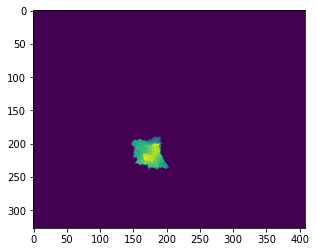

In [9]:
#regionMap[0,:,4]
# pull out individual pore for plotting, after labelling has occurred
testIM = np.where(snowFilt.regions == 1,False, True)
test = ps.visualization.show_3D(testIM)
plt.imshow(test)
ps.io.to_vtk(testIM,'pulledOutPore.vtk')

In [12]:
# look up number of regions
print(f"Number of regions: {np.unique(snowFilt.regions).size}")

Number of regions: 984


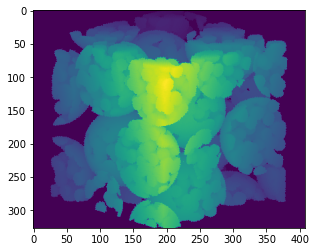

In [133]:
# visualize the entire pore space for reference
test = ps.visualization.show_3D(poreImage)
plt.imshow(test)


(array([265., 162.,  90.,  12.,  11.,   4.,   8.,   4.,   3.,   3.,   4.,
          4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.08030e-17, 6.77600e-08, 1.35520e-07, 2.03280e-07, 2.71040e-07,
        3.38800e-07, 4.06560e-07, 4.74320e-07, 5.42080e-07, 6.09840e-07,
        6.77600e-07, 7.45360e-07, 8.13120e-07, 8.80880e-07, 9.48640e-07,
        1.01640e-06, 1.08416e-06, 1.15192e-06, 1.21968e-06, 1.28744e-06,
        1.35520e-06]),
 <a list of 20 Patch objects>)

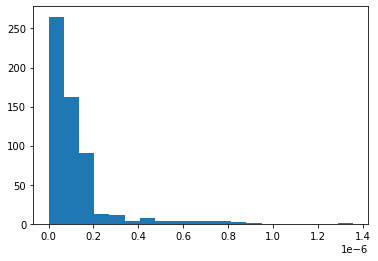

In [13]:
# Plot histogram of pore velocities
poreLabel = '2'
poreVelNorm = velocities.get(poreLabel)

n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
# We can set the number of bins with the `bins` kwarg
plt.hist(poreVelNorm, bins=n_bins)

(array([ 87., 243., 205., 170., 122.,  70.,  26.,   4.,   5.,   2.,   8.,
         15.,   9.,   7.,   2.,   3.,   0.,   1.,   2.,   2.]),
 array([ 0.26794919,  2.69183509,  5.11572098,  7.53960687,  9.96349276,
        12.38737866, 14.81126455, 17.23515044, 19.65903634, 22.08292223,
        24.50680812, 26.93069401, 29.35457991, 31.7784658 , 34.20235169,
        36.62623758, 39.05012348, 41.47400937, 43.89789526, 46.32178116,
        48.74566705]),
 <a list of 20 Patch objects>)

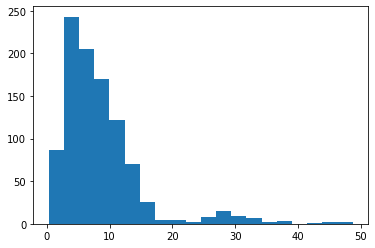

In [15]:
# Plot histogram of pore diameters

poreDiam = poreInfo['pore.diameter']
plt.hist(poreDiam, bins=20)

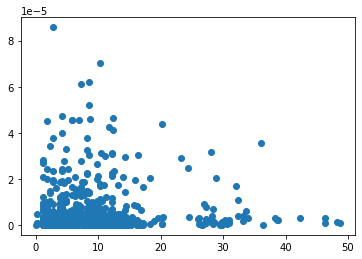

In [22]:
nRegions = np.unique(snowFilt.regions).size
poreDiamVec = np.zeros(nRegions,)
velNormPoreVec = np.zeros(nRegions,)
for a in range(0, poreInfo['pore.diameter'].size):
    poreDiamVec[a] = poreInfo['pore.diameter'][a]
    velNormPoreVec[a] = np.median(velocities.get(str(a)))

# Current problem is that the velocities dictionary doesn't have a value for label 53 for some reason
# this causes problems here! Fix!
plt.scatter(poreDiamVec,velNormPoreVec)

In [17]:
a
velocities.get(str(a))

[1.9745e-06,
 8.7739e-07,
 4.6702e-07,
 8.7696e-07,
 1.4678e-06,
 2.181e-06,
 1.7757e-06,
 3.3497e-06,
 2.8623e-06,
 1.6027e-06,
 3.2771e-06,
 9.2571e-07,
 2.1774e-06,
 7.1714e-07,
 1.17e-06,
 6.5664e-07,
 7.1978e-07,
 9.8524e-07,
 1.6608e-06,
 1.1293e-06,
 2.2094e-06,
 2.1712e-06,
 1.7384e-06,
 7.1811e-07,
 1.44e-06,
 2.3628e-06,
 2.8639e-06,
 2.652e-06,
 2.0638e-06,
 7.3495e-07,
 1.7252e-06,
 3.3416e-06,
 3.0209e-06,
 1.9101e-06,
 1.492e-06,
 2.9909e-06,
 2.0153e-06,
 1.911e-06,
 1.3027e-06,
 9.3106e-07,
 9.5533e-07,
 5.112e-07,
 5.3469e-07,
 1.2808e-07,
 2.0565e-07,
 3.6144e-07,
 1.9795e-06,
 5.8506e-07,
 3.3186e-07,
 5.2007e-08,
 8.5185e-07,
 1.3535e-06,
 1.6875e-06,
 2.0186e-06,
 3.1179e-06,
 3.265e-06,
 2.7354e-06,
 4.5071e-07,
 5.2883e-07,
 1.0357e-06,
 1.6501e-06,
 2.2481e-06,
 3.1248e-06,
 3.6184e-06,
 3.6093e-06,
 2.7395e-06,
 1.234e-06,
 1.2112e-06,
 2.2163e-06,
 3.3535e-06,
 3.8252e-06,
 3.5984e-06,
 2.24e-06,
 1.9411e-06,
 3.6085e-06,
 3.6421e-06,
 2.2978e-06,
 1.5703e-06,

983